# How the Pandemic Affected Conspiracy Theories on Reddit?
### Sentiment Analysis and Topic Modelling
#### Author: Son N. Nguyen

*Find the project repo [here](https://github.com/nszoni/reddit_conspiracy_theories)*


## Hypothesis

My hypothesis is that since the pandemic, there has been more activity and discussions have been more aggressive in the r/conspiracy subreddit. To find that out, my idea was to use VADER sentiment intensity analysis to find out how things have changed in the post-covid world.

Besides, I wanted to see using LDA topic modelling whether topics have been shifted from vaccines, global warming, 5G to other, maybe related to the war, the BLM movement, LGBTQ etc. I believe that there is a trend towards the discussion of human rights and questions revolving around society.

## Requirements

To make sure you have all the necessary modules installed, I have created a requirements.txt file.

```
pip install -r requirements.txt

```

### Import the required modules:

In [273]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import emoji
import regex


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nszoni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Collection

### Kaggle

Initially, my plan was to used a dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-conspiracy-theory). It is claimed to be updated daily but the dataset is relatively small. Since there were no external data sources available out of the box, I decided to scrape it myself from the API.

### Scraping Reddit

The traditional way of scraping reddit is to use the API with the PRAW wrapper. However, the API is limited to 1000 requests per hour and is not able to scrape historical data defined by a window. This is not enough for our purposes and our data would be highly unbalanced and biased.

> [PRAW](https://github.com/praw-dev/praw), an acronym for "Python Reddit API Wrapper", is a Python package that allows for simple access to Reddit's API.

#### Overcoming limitations of the Reddit API with Pushift API

Luckily there is a service which allows us to scrape historical data from Reddit. The service is called [Pushift API](https://github.com/pushshift/api). Briefly, it let's us control the scraping window. The python wrapper of the API is called PSAW, but there is also a multi-threaded version called PMAW which is more efficient in high volumes close to hundreds of thousands of records.

> “Pushshift makes it much easier for researchers to query and retrieve historical Reddit data, provides extended functionality by providing fulltext search against comments and submissions, and has larger single query limits.” PSAW, meanwhile, makes it easier to work with Pushshift and provides better documentation."

#### Scraping process

I have used a methodology which blends together the usage of the classical PRAW and PSAW. With PSAW, we only get unique idenfiers of submissions from the API bounded by time, which then we feed it to PRAW's submission endpoint. This way, we can get more features offered by PRAW but overcome its limitation of scraping historical data. For a more detailed reference check out this blogpost [here](https://towardsdatascience.com/how-to-collect-a-reddit-dataset-c369de539114).

The script used for scraping can be found in the project's root directory under the name `reddit_pushift_scraper.py`.

## Data Ingestion

I have scraped **2500 submissions between 2016 and 2020** for the analysis of conspiracy theories and subreddit activity. For comparison, I also got submission-level data between **2021 and 2022** which should be the baseline for the aftermath of the global pandemic.

### Pre-covid conspiracy posts between 2018 and 2019

In [167]:
rc_precovid = pd.read_csv('../data/reddit_ct_pushift_2018_2019.csv')
rc_precovid.head()

,id,author,url,title,score,num_comments,created,body
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted]
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed]
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ..."
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...


### Post-covid top conspiracy post between 2021 and 2022

In [168]:
rc_postcovid = pd.read_csv('../data/reddit_ct_pushift_2021_2022.csv')
rc_postcovid.head()

,id,author,url,title,score,num_comments,created,body
0,ua5ej6,EurekaStockade,https://www.reddit.com/r/conspiracy/comments/u...,"Nuclear Energy--""too cheap to meter""--thats wh...",1,1,1.650720e+09,Before WW2--Globalists realized that cheap nuc...
1,ua58qr,MSA966,https://www.reddit.com/r/conspiracy/comments/u...,Why iPhone face recognition works even though ...,1,2,1.650720e+09,NaN
2,ua55yb,Ancient-Soup2098,https://www.reddit.com/r/conspiracy/comments/u...,Do you think we are the virus?,2,3,1.650720e+09,I’m not necessarily religious/spiritual but I ...
3,ua53xn,jomtienislife,https://youtu.be/DvzqTvafVu0,Russian Ministry of Defense warns of planned p...,0,2,1.650719e+09,NaN
4,ua502a,Mouse1701,https://www.reddit.com/r/conspiracy/comments/u...,Disney world just lost it's government status,4,8,1.650719e+09,Walt Disney world has just lost it's ablilty t...


## Data Cleaning

First, I wanted to label each dataset before concatenating them to segment by the pre-coviid and post-covid data in later analyses. The creation date was given in UNIX time in the raw data which had to be converted into a human-readable format.

In [169]:
# Label dataframes and union

rc_precovid['label'] = 'precovid'
rc_postcovid['label'] = 'postcovid'

rc = pd.concat([rc_precovid, rc_postcovid], axis=0)
rc['timestamp'] = rc['created'].apply(dt.fromtimestamp)

rc.head()

,id,author,url,title,score,num_comments,created,body,label,timestamp
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted],precovid,2019-12-30 23:38:29
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed],precovid,2019-12-30 23:37:08
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ...",precovid,2019-12-30 23:36:27
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN,precovid,2019-12-30 23:32:52
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...,precovid,2019-12-30 23:24:35


In [170]:
# replace [deleted] or [removed] with empty string
rc['body'] = rc['body'].replace('[deleted]', np.nan)
rc['body'] = rc['body'].replace('[removed]', np.nan)

#### Glue together title and body of a submission

We could either do the analysis separately for post titles and body texts, but it would mean that we lose significant amount of data due to fanning through post which only have a title.

As a result, I have decided to keep the analysis concise and concatenate together the two features. The limitation of this manouver is that there are cases where the titles are just the first line of the body text.

In [171]:
# Concat together title and body text
rc['text'] = rc['title'].fillna('') + ' ' + rc['body'].fillna('')

In [172]:
rc.drop(['id', 'url', 'created', 'body', 'title'], axis=1, inplace=True)

rc.head()

,author,score,num_comments,label,timestamp,text
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...


In [173]:
# observe missing values in text column
rc['text'].isna().sum()

0

In [174]:
# find values with only spaces
rc[rc['text'].str.strip().str.len() == 0]

,author,score,num_comments,label,timestamp,text


No missing values or whitespaces in our data!

In [175]:
rc.shape

(5000, 6)

## Text Processing

#### Extend stopwords corpus

In [176]:
#add words to stopword list
stop_words = stopwords.words('english')
stop_words.extend(['use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'one', 'many', 'well', 'two', 'say', 'would', 'make', 'get', 'go', 'thing', 'much'])

In [177]:
lemmatizer = WordNetLemmatizer()

def text_preprocess_lemmatize(text: str) -> str:
    
    '''
    - remove handlers (eg. @username)
    - remove urls
    - remove any non-word elements (inc. punctuation)
    - remove single letters
    - remove digits
    - replace multiple spaces with a single space
    - tokenize text
    - filter out stopwords
    - lemmatize tokens
    - filter out tokens with less than 3 characters
    '''
    garbage = re.compile('@[^\s]+|http\S+|\W|\s+[a-zA-Z]\s+|\d+|\s+')
    
    text = text.lower()
    text= re.sub(garbage,' ', text)
    
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stopwords.words('english'))]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

### Apply text processer

In [178]:
rc['cleaned'] = rc['text'].apply(text_preprocess_lemmatize)

In [179]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...


## Feature Engineering

> [VADER](https://github.com/cjhutto/vaderSentiment) is a lexicon and rule-based feeling analysis instrument that is explicitly sensitive to suppositions communicated in web-based media. VADER utilizes a mix of lexical highlights (e.g., words) that are, for the most part, marked by their semantic direction as one or the other positive or negative. Thus, VADER not only tells about the Polarity score yet, in addition, it tells us concerning how positive or negative a conclusion is.

In [180]:
# Apply SIA from Vader package
sid = sia()

# lowercase and remove all non-alphabetic elements
rc['sentiments'] = rc['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [181]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp..."
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co..."
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp..."


In [182]:
# Parse out dict elements

rc['positive'] = rc['sentiments'].apply(lambda x: x['pos']) 
rc['neutral'] = rc['sentiments'].apply(lambda x: x['neu'])
rc['negative'] = rc['sentiments'].apply(lambda x: x['neg'])
rc['compound'] = rc['sentiments'].apply(lambda x: x['compound'])

In [183]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341


We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. There's some testing and experimentation that goes with choosing these ranges, and there is a trade-off to be made here. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

Let's create a positive label of 1 if the compound is greater than 0.2, and a label of -1 if compound is less than -0.2. Everything else will be 0.

In [184]:
THRESHOLD = 0.2

conditions = [
    (rc['compound'] <= -THRESHOLD),
    (rc['compound'] > -THRESHOLD) & (rc['compound'] < THRESHOLD),
    (rc['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
rc['sentiment'] = np.select(conditions, values)

In [185]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500,neg
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963,pos
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341,neg


In [186]:
def ct_title_output(df, label):
  res = df[df['sentiment'] == label].text.values
  print(f'{"=" * 20}')
  print("\n".join(text for text in res))

# randomly sample
ct_sub = rc.groupby('sentiment').sample(n = 3, random_state = 7)

print("Positive theory")
ct_title_output(ct_sub, "pos")

print("\nNeutral theory")
ct_title_output(ct_sub, "neu")

print("\nNegative theory")
ct_title_output(ct_sub, "neg")

Positive theory
Why is everyone going crazy? I just had a Reddit experience irl! Went to the dispensary for 420 sales and as I’m trying to pay there is a couple standing in front of both registers, the employee asks me to come to the register, but this dude is standing right in front of it, so I come up next to him and my arm barely grazed him, I almost didn’t even feel it. He starts talking all this shit about being run into and rude as people trying to knock him over in the dispensary. (He was at least 6’1 250-300 I am a 5’8 female and I weigh 150.)

I said sir I barely grazed you, he flips out more after one or two more sentences back and forth I said you I hope you have a good day dude. He says I hope you fucking don’t. Then his girl starts stalking about keying my car (I walked there, but they didn’t know that) and he starts talking about how I better not bump into him outside. 

Wtf. I am 41 years old and I’ve never had a stranger talk to me like this, I felt like I was talking t

### Feature Extraction

### Let's carve out some naive metrics like the number of words, stopwords, the average word lenght, and the number of question marks.

In [187]:
rc['num_words'] = rc['text'].apply(lambda x: len(x.split(' ')))
rc['num_stopwords'] = rc['text'].apply(lambda x: len([word for word in x.split(' ') if word in list(stop_words)]))
rc['avg_word_length'] = rc['text'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(stop_words)])))
rc['num_question_mark'] = rc['text'].apply(lambda x: len([va for va in x.split(' ') if va == '?']))

### Count emojis

In [239]:
def count_emoji(text):
    total_emoji = 0
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):  
            total_emoji += 1

    return total_emoji


In [240]:
rc['num_emoji'] = rc['text'].apply(count_emoji)

In [259]:
rc[rc['num_emoji'] > 5].head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length,num_question_mark,num_emoji
463,elisa_bp101,0,10,postcovid,2022-04-22 18:34:54,JESUS CHRIST is an Alien God that's why he Res...,jesus christ alien god resurrected dead real t...,"{'neg': 0.092, 'neu': 0.774, 'pos': 0.134, 'co...",0.134,0.774,0.092,0.8372,pos,397,168,6.069869,0,8
987,Hedggiekilla419,11,5,postcovid,2022-04-21 20:08:59,"Regardless of what 💩 MSM is pushing, inflation...",regardless msm pushing inflation caused russia...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu,26,9,6.000000,0,9
1615,arnott,7,7,postcovid,2022-04-20 16:34:59,BCG 💩 Victoria’s Secret 👙 Jeffrey Epstein 🧟 Ke...,bcg victoria secret jeffrey epstein kenneth gr...,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",0.000,0.916,0.084,-0.2960,neg,33,8,4.240000,0,6


In [277]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [278]:
#apply split count to column text
rc['emoji_list'] = rc['text'].apply(split_count)

In [279]:
rc[rc['num_emoji'] > 5].head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length,num_question_mark,num_emoji,emoji_list
463,elisa_bp101,0,10,postcovid,2022-04-22 18:34:54,JESUS CHRIST is an Alien God that's why he Res...,jesus christ alien god resurrected dead real t...,"{'neg': 0.092, 'neu': 0.774, 'pos': 0.134, 'co...",0.134,0.774,0.092,0.8372,pos,397,168,6.069869,0,8,"[🛡️, 🙄, 😉, 🛸, 🌎, 🕳️, 🌀, 🚽]"
987,Hedggiekilla419,11,5,postcovid,2022-04-21 20:08:59,"Regardless of what 💩 MSM is pushing, inflation...",regardless msm pushing inflation caused russia...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu,26,9,6.000000,0,9,"[💩, 💯, 🤦, 🖍️, 🍌, 🦧, 🚀, 🌚, 💯]"
1615,arnott,7,7,postcovid,2022-04-20 16:34:59,BCG 💩 Victoria’s Secret 👙 Jeffrey Epstein 🧟 Ke...,bcg victoria secret jeffrey epstein kenneth gr...,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",0.000,0.916,0.084,-0.2960,neg,33,8,4.240000,0,6,"[💩, 👙, 🧟, 🏰, 🧶, 🕸]"


## EDA

### Distributions

### Do people write lenghtier posts after COVID?

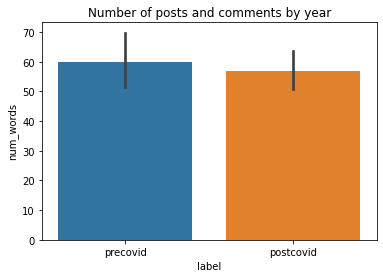

In [192]:
sns.barplot(x='label', y='num_words', data=rc)
plt.title('Number of posts and comments by year')
plt.show()

### Distribution of sentiment categories

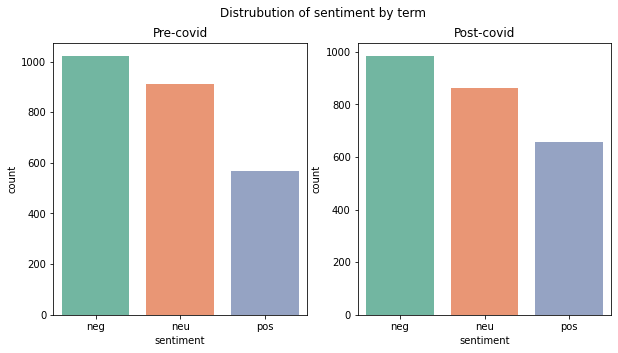

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Distrubution of sentiment by term')

# Pre-covid
sns.countplot(ax=axes[0], x='sentiment', data=rc[rc['label']=='precovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[0].set_title('Pre-covid')

# Post-covid
sns.countplot(ax=axes[1], x='sentiment', data=rc[rc['label']=='postcovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[1].set_title('Post-covid')

plt.show()

Text(0.5, 1.0, 'Negative')

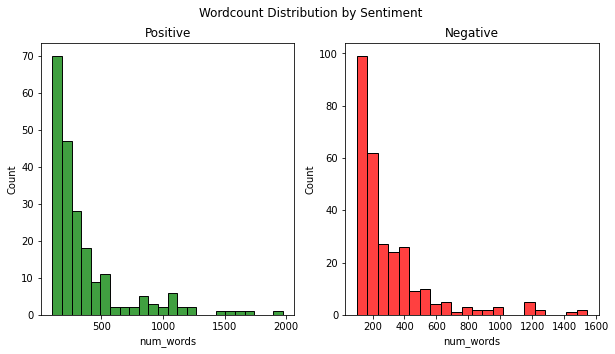

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Wordcount Distribution by Sentiment')


sns.histplot(rc[(rc['sentiment']=='pos') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[0],color='green')
axes[0].set_title('Positive')

sns.histplot(rc[(rc['sentiment']=='neg') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[1],color='red')
axes[1].set_title('Negative')

### Time based analysis

In [195]:
#Sorting And Feature Engineering
rc_ts = rc.sort_values(by='timestamp')
rc_ts=rc_ts.copy()
rc_ts = rc_ts.rename(columns={'timestamp':'date'})
rc_ts['year']         = pd.DatetimeIndex(rc_ts['date']).year
rc_ts['month']        = pd.DatetimeIndex(rc_ts['date']).month
rc_ts['day']          = pd.DatetimeIndex(rc_ts['date']).day
rc_ts['quarter']      = pd.DatetimeIndex(rc_ts['date']).quarter

In [196]:
rc_ts.head()

,author,score,num_comments,label,date,text,cleaned,sentiments,positive,neutral,...,sentiment,num_words,num_stopwords,avg_word_length,num_question_mark,num_emoji,year,month,day,quarter
2499,NaN,3,4,precovid,2019-12-17 18:22:12,Not long after making it to the top of r/all t...,long making top post removed sub,"{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...",0.101,0.899,...,pos,18,9,4.222222,0,0,2019,12,17,4
2498,NaN,5,5,precovid,2019-12-17 18:23:27,"Posting about bots, gets called out, op become...",posting bot get called becomes deleted bot com...,"{'neg': 0.107, 'neu': 0.893, 'pos': 0.0, 'comp...",0.000,0.893,...,neg,17,2,5.400000,0,0,2019,12,17,4
2497,bmac3434,9,16,precovid,2019-12-17 18:25:04,"From 2009 to 2015, for example, more than 10,7...",example application electronic surveillance su...,"{'neg': 0.148, 'neu': 0.793, 'pos': 0.059, 'co...",0.059,0.793,...,neg,34,15,6.947368,0,0,2019,12,17,4
2496,nailpolisher,13,4,precovid,2019-12-17 18:28:14,Why you are consuming tons of fake news every ...,consuming ton fake news every day,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp...",0.000,0.744,...,neg,11,3,4.000000,0,0,2019,12,17,4
2495,NaN,114,42,precovid,2019-12-17 18:29:26,"Questioning MSM narratives isn't ""Pro-Trump"", ...",questioning msm narrative pro trump regardless...,"{'neg': 0.187, 'neu': 0.678, 'pos': 0.136, 'co...",0.136,0.678,...,neg,50,27,6.956522,0,0,2019,12,17,4


### User trends and user activity

<AxesSubplot:xlabel='label', ylabel='author'>

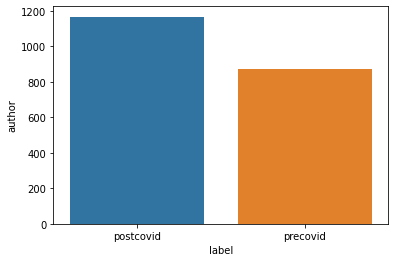

In [227]:
# barplot of unique authors
authors_freq = rc.groupby('label').author.nunique().reset_index()

sns.barplot(x='label', y='author', data=authors_freq)

### Emoticon analysis

#### Positive emojis

In [307]:
# generate emoji frequencies for positive posts
pos_counter = Counter()
for item in rc[rc['sentiment'] == 'pos']['emoji_list']:
    pos_counter.update(item)

pos_emojis = pd.DataFrame.from_dict(pos_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

pos_emojis.nlargest(5, 'count')

,emoji,count
1,😂,10
0,🤣,2
3,❤️,2
11,🤡,2
14,🙄,2


### Negative emojis

In [308]:
# generate emoji frequencies for negative posts
neg_counter = Counter()
for item in rc[rc['sentiment'] == 'neg']['emoji_list']:
    neg_counter.update(item)

neg_emojis = pd.DataFrame.from_dict(neg_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

neg_emojis.nlargest(5, 'count')

,emoji,count
9,🤔,5
0,📷,4
6,😂,4
36,👀,3
15,🤨,2


## Sentiment Analysis

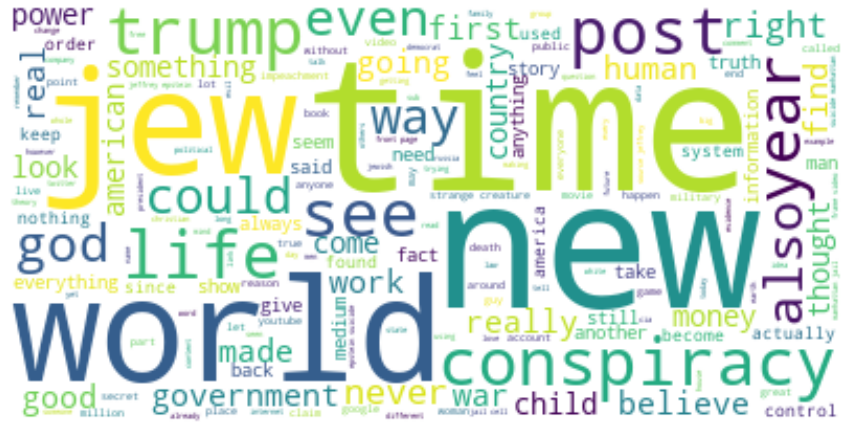

In [204]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
precovid_wc = rc[rc['label'] == 'precovid']
words = ''
for sentence in precovid_wc['cleaned']:
    words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

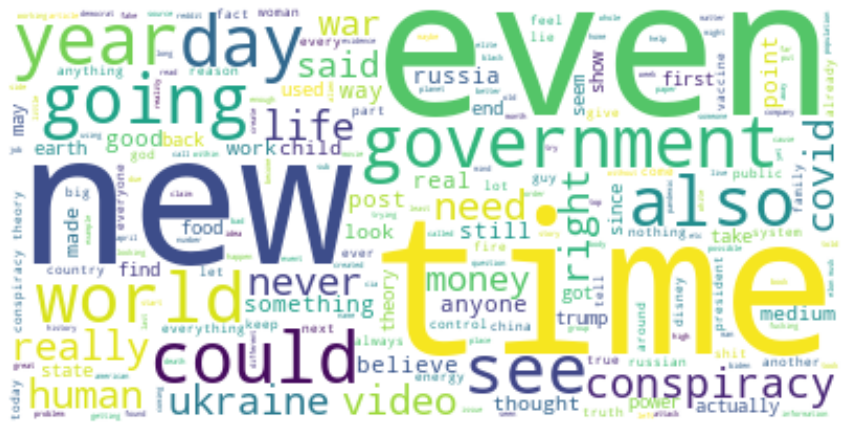

In [205]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
postcovid_wc = rc[rc['label'] == 'postcovid']
words = ''
for sentence in postcovid_wc['cleaned']:
    words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

### Visualize positive and negative words 

### Entity frequency

### Bi and Tri-grams

In [208]:
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(rc['cleaned'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [209]:
df_ngram.head()

,frequency,bigram/trigram
0,129,conspiracy theory
1,81,strange creature
2,74,jeffrey epstein
3,64,front page
4,63,year ago


<AxesSubplot:xlabel='frequency', ylabel='bigram/trigram'>

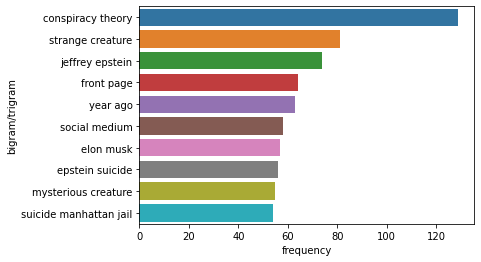

In [218]:
# seaborn barplot top 10 bigrams
sns.barplot(y='bigram/trigram', x='frequency', data=df_ngram.nlargest(10, 'frequency'))

## Topic Modelling (LDA)

In [214]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,3))
lda = LatentDirichletAllocation(n_components=5)

pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(rc['cleaned'])

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names_out(), n_top_words=3)

Topic #0: jeffrey epstein, epstein suicide, source jeffrey epstein
Topic #1: conspiracy theory, done time, conspiracy theory true
Topic #2: strange creature, creature forest, frame video
Topic #3: front page, tiananmen square, page reddit
Topic #4: conspiracy theory, double standard, exposing pedophocracy

